In [20]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
all_data = pd.read_csv(r'C:\Users\Gebruiker\Documents\thesiscode\experimental\preprocessed_wine.csv', index_col=0)
errors = all_data['errors']
clustering_features_preprocessed = all_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

In [3]:
to_scale = ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
clustering_features_preprocessed[to_scale] = StandardScaler().fit_transform(clustering_features_preprocessed[to_scale])

clustering_features_preprocessed[:2]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
12,0.687846,-0.160373,0.141557,-0.694417,-0.834587,0.004312,0.267992,-0.318793,0.017405,0.697247,0.405843,-0.146241,1.256507
23,-0.356751,-0.343481,0.502356,-0.101678,-0.381526,-0.222556,-0.278564,-0.635733,-0.650337,-0.367414,-0.033392,1.394286,0.408775


In [4]:
# is used to calculate the F-score of the instances in the clusters.
# requires the all_data dataframe (with predicted and true class, but the errors col is not needed)

def F_score(results, class_number):
    true_pos = results.loc[results["true_class"] == class_number][results["predicted_class"] == class_number]
    true_neg = results.loc[results["true_class"] != class_number][results["predicted_class"] != class_number]
    false_pos = results.loc[results["true_class"] != class_number][results["predicted_class"] == class_number]
    false_neg = results.loc[results["true_class"] == class_number][results["predicted_class"] != class_number]
    
    try:
        precision =  len(true_pos)/(len(true_pos) + len(false_pos))
    except ZeroDivisionError:
        return 0
    try:
        recall = len(true_pos)/(len(true_pos) + len(false_neg))
    except ZeroDivisionError:
        return 0

    # TODO solve the "float division by zero" error
    try:
        f_score = 2 * ((precision * recall)/(precision + recall))
    except ZeroDivisionError:
        return 0
        
    return f_score

# Calculating the macro average F-score --> will eventually be replaced with weighted F-score
def mean_f_score(results):
    classes = results['true_class'].unique()
    class_list = []
    for i in classes:
        class_i = F_score(results, i)
        class_list.append(class_i)
    mean_f_score = (sum(class_list))/len(classes)
    print('this is the mean F-score of all classes within this cluster in the list: ', mean_f_score)

    return(mean_f_score)

# Calculating the bias for each cluster
def calculate_bias(clustered_data, cluster_number):
    cluster_x = clustered_data.loc[clustered_data["clusters"] == cluster_number]
    remaining_clusters = clustered_data.loc[clustered_data["clusters"] != cluster_number]
    
    # Bias definition: 
    return mean_f_score(remaining_clusters) - mean_f_score(cluster_x)


In [5]:
clus_model_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}


In [6]:
# calculate the variances of the errors column
def calculate_variance(data):
    # Receives the data within one cluster to calculate the variance

    # Obtain errors column
    errors_col = data['errors']
    # Number of observations
    n = len(data)
    # Mean of the data
    mean = sum(errors_col)/n
    # Squared deviation 
    deviations = [(x - mean) ** 2 for x in errors_col]
    # Variance
    variance = sum(deviations) / n
    return variance

def get_highest_var_cluster(data):
    clusters = data['clusters'].unique()
    highest_variance = 0
    best_cluster = None
    cluster_number = None
    for i in clusters:
        print('this is i:', i)
        cluster_i = data[data['clusters'] == i]
        variance_cluster = calculate_variance(cluster_i)
        print('variance cluster:', variance_cluster)
        print('highest variance:', highest_variance)

        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            best_cluster = cluster_i
            cluster_number = i
            print('this is the cluster number:', cluster_number)

    return cluster_number


In [17]:
def plot_clusters(data):
    scatterplot = sns.scatterplot(data=data, x="alcohol", y="ash", hue="clusters")

    plt.show()
    


In [23]:
# Initialisation of clustering_features
clustering_features_preprocessed['clusters'] = 1
clustering_features = clustering_features_preprocessed
# all_data.head(5) #true class doesnt seem to have the right values? I see no 2 or 3

clustering_features.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,clusters,true_class,predicted_class
12,0.687846,-0.160373,0.141557,-0.694417,-0.834587,0.004312,0.267992,-0.318793,0.017405,0.697247,0.405843,-0.146241,1.256507,1,0.0,0
23,-0.356751,-0.343481,0.502356,-0.101678,-0.381526,-0.222556,-0.278564,-0.635733,-0.650337,-0.367414,-0.033392,1.394286,0.408775,1,0.0,1
25,-0.124619,0.290352,2.798346,2.269277,1.808272,0.061029,0.155878,1.582845,0.227267,-0.590546,0.259431,0.486852,-0.105424,1,0.0,0
35,0.374467,-0.047692,0.141557,0.787430,-0.003974,0.193369,0.576306,-0.635733,0.112797,0.378486,-0.399421,1.056636,0.144727,1,0.0,1
13,1.848509,-0.160373,0.075958,-2.209194,-0.683567,0.949596,1.571320,1.160258,1.925240,0.569743,1.137900,-0.504994,0.784001,1,0.0,2


    0.0                0  
35         0         0.0                1  
13         0         0.0                2  
this is the mean F-score of all classes within this cluster in the list:  0.5517241379310345
this is the mean F-score of all classes within this cluster in the list:  0.3125
<ipython-input-4-8b3a47c229f7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_neg = results.loc[results["true_class"] != class_number][results["predicted_class"] != class_number]
<ipython-input-4-8b3a47c229f7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  false_pos = results.loc[results["true_class"] != class_number][results["predicted_class"] == class_number]
<ipython-input-4-8b3a47c229f7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_pos = results.loc[results["true_class"] == class_number][results["predicted_class"] == class_number]
<ipython-input-4-8b3a47c229f7>:6: UserWarning: Boolean S

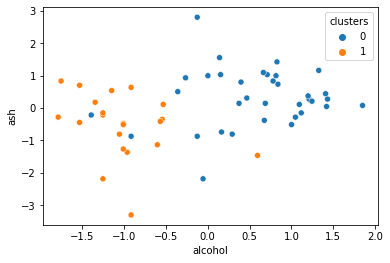

this is i: 0
variance cluster: 0.24305555555555547
highest variance: 0
this is the cluster number: 0
this is i: 1
variance cluster: 0.2358276643990929
highest variance: 0.24305555555555547
the end
Value for x: 0
new clustering features after merge: <ipython-input-22-4dc26b7e7d53>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_bias_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(high_bias_cluster),index=high_bias_cluster.index)
<ipython-input-4-8b3a47c229f7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_pos = results.loc[results["true_class"] == class_number][results["predicted_class"] == class_number]
<ipython-input-4-8b3a47c229f7>:6: UserWarning: Boolean Series key will be reindexed to m

In [22]:
MAX_ITER = 10 # --> in each iteration we split on the cluster with the highest variance
x = 1 # cluster number
bias_prev_iteration_cluster = 0

for i in range(1, MAX_ITER):
    print('Value for x:', x)
    # select the instances with cluster X as dataset
    high_bias_cluster = clustering_features.loc[clustering_features['clusters'] == x]
    high_bias_cluster.drop('clusters', axis=1)

    # Apply Kmeans 
    kmeans_algo = KMeans(n_clusters=2, **clus_model_kwargs).fit(high_bias_cluster) 
    high_bias_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(high_bias_cluster),index=high_bias_cluster.index) 
    
    new_clustering_features = clustering_features
    new_clustering_features['clusters'] = high_bias_cluster['new_clusters'].combine_first(new_clustering_features['clusters'])
    # new_clustering_features = new_clustering_features.merge(all_data, on=all_data['true_class'], how='left')
    new_clustering_features['true_class'] = all_data[['true_class']]
    new_clustering_features['predicted_class'] = all_data[['predicted_class']]

    #todo: check whether adding the predicted and true class now works
    print('new clustering features after merge:', new_clustering_features.head(5))
    
    # calculate bias for each of the two clusters
    negative_bias_0 = calculate_bias(new_clustering_features, 0)
    negative_bias_1 = calculate_bias(new_clustering_features, 1)

    new_clustering_features.drop(['true_class', 'predicted_class'], axis=1)

    if max(negative_bias_0, negative_bias_1) >= bias_prev_iteration_cluster:
        # select cluster with highest negative bias and merge new cluster assignments with the df
        bias_prev_iteration_cluster = max(negative_bias_0, negative_bias_1)
        clustering_features = new_clustering_features
        plot_clusters(clustering_features)
    else:
        break
        print('no clusters with a higher bias are left')
    
    clustering_features = clustering_features.join(errors, how='left')
    x = get_highest_var_cluster(clustering_features)
    clustering_features = clustering_features.drop('errors', axis=1)
    print('the end')


Possible solution for the boolean indexing error:
https://www.reddit.com/r/learnpython/comments/53yjbe/pandas_boolean_filtering/

In [ ]:
# exporting the biased cluster dataframe for further analysis
# resulting_cluster.to_csv('identified_cluster.csv')

In [ ]:
        # new_clustering_features = clustering_features.join(high_bias_cluster['new_clusters'], how='left')
    
    # new_clustering_features['clusters'] = new_clustering_features['new_clusters'].combine_first(new_clustering_features['clusters'])
    # new_clustering_features.drop('new_clusters', axis=1)